In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from TSMixer import TSMixerEstimator

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)),
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

In [4]:
print(dataset.metadata.prediction_length)

24


In [5]:
estimator = TSMixerEstimator(
    #distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling="std",
    
    depth=2,
    dim=32,
    expansion_factor=2,

    batch_size=32,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(accelerator="cuda", max_epochs=10)
)

In [6]:
predictor = estimator.train(
    training_data=dataset_train, 
    cache_data=True, 
    shuffle_buffer_length=1024, 
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\maerzale\.virtualenvs\ConvTS_Mixer-3Rl3B8jo\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
C:\Users\maerzale\.virtualenvs\ConvTS_Mixer-3Rl3B8jo\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RAN

Training: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'train_loss' reached 4.82248 (best 4.82248), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS Mixer\\lightning_logs\\version_116\\checkpoints\\epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 4.02797 (best 4.02797), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS Mixer\\lightning_logs\\version_116\\checkpoints\\epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 3.89316 (best 3.89316), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS Mixer\\lightning_logs\\version_116\\checkpoints\\epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 3.81659 (best 3.81659), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS Mixer\\lightning_logs\\version_116\\checkpoints\\epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 3.76663 (best 3.76663), saving model to 'C:\\Users\\maerzale\\OneDrive - adidas\\ConvTS M

In [7]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)

In [8]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

In [9]:
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 82.70it/s]
Running evaluation: 7it [00:00, 82.66it/s]
Running evaluation: 7it [00:00, 82.72it/s]
Running evaluation: 7it [00:00, 82.68it/s]
Running evaluation: 7it [00:00, 82.66it/s]
Running evaluation: 7it [00:00, 82.65it/s]
Running evaluation: 7it [00:00, 69.78it/s]
Running evaluation: 7it [00:00, 82.73it/s]
Running evaluation: 7it [00:00, 69.81it/s]
Running evaluation: 7it [00:00, 82.65it/s]
Running evaluation: 7it [00:00, 82.69it/s]
Running evaluation: 7it [00:00, 58.75it/s]
Running evaluation: 7it [00:00, 64.04it/s]
Running evaluation: 7it [00:00, 62.29it/s]
Running evaluation: 7it [00:00, 66.22it/s]
Running evaluation: 7it [00:00, 67.47it/s]
Running evaluation: 7it [00:00, 59.97it/s]
Running evaluation: 7it [00:00, 64.37it/s]
Running evaluation: 7it [00:00, 64.39it/s]
Running evaluation: 7it [00:00, 59.98it/s]
Running evaluation: 7it [00:00, 55.25it/s]
Running evaluation: 7it [00:00, 67.47it/s]
Running evaluation: 7it [00:00, 60.51it/s]
Running eva

In [10]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.3570134831482524
ND: 0.49975720112953814
NRMSE: 0.961784547217443
MSE: 877.4722232497066


In [11]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

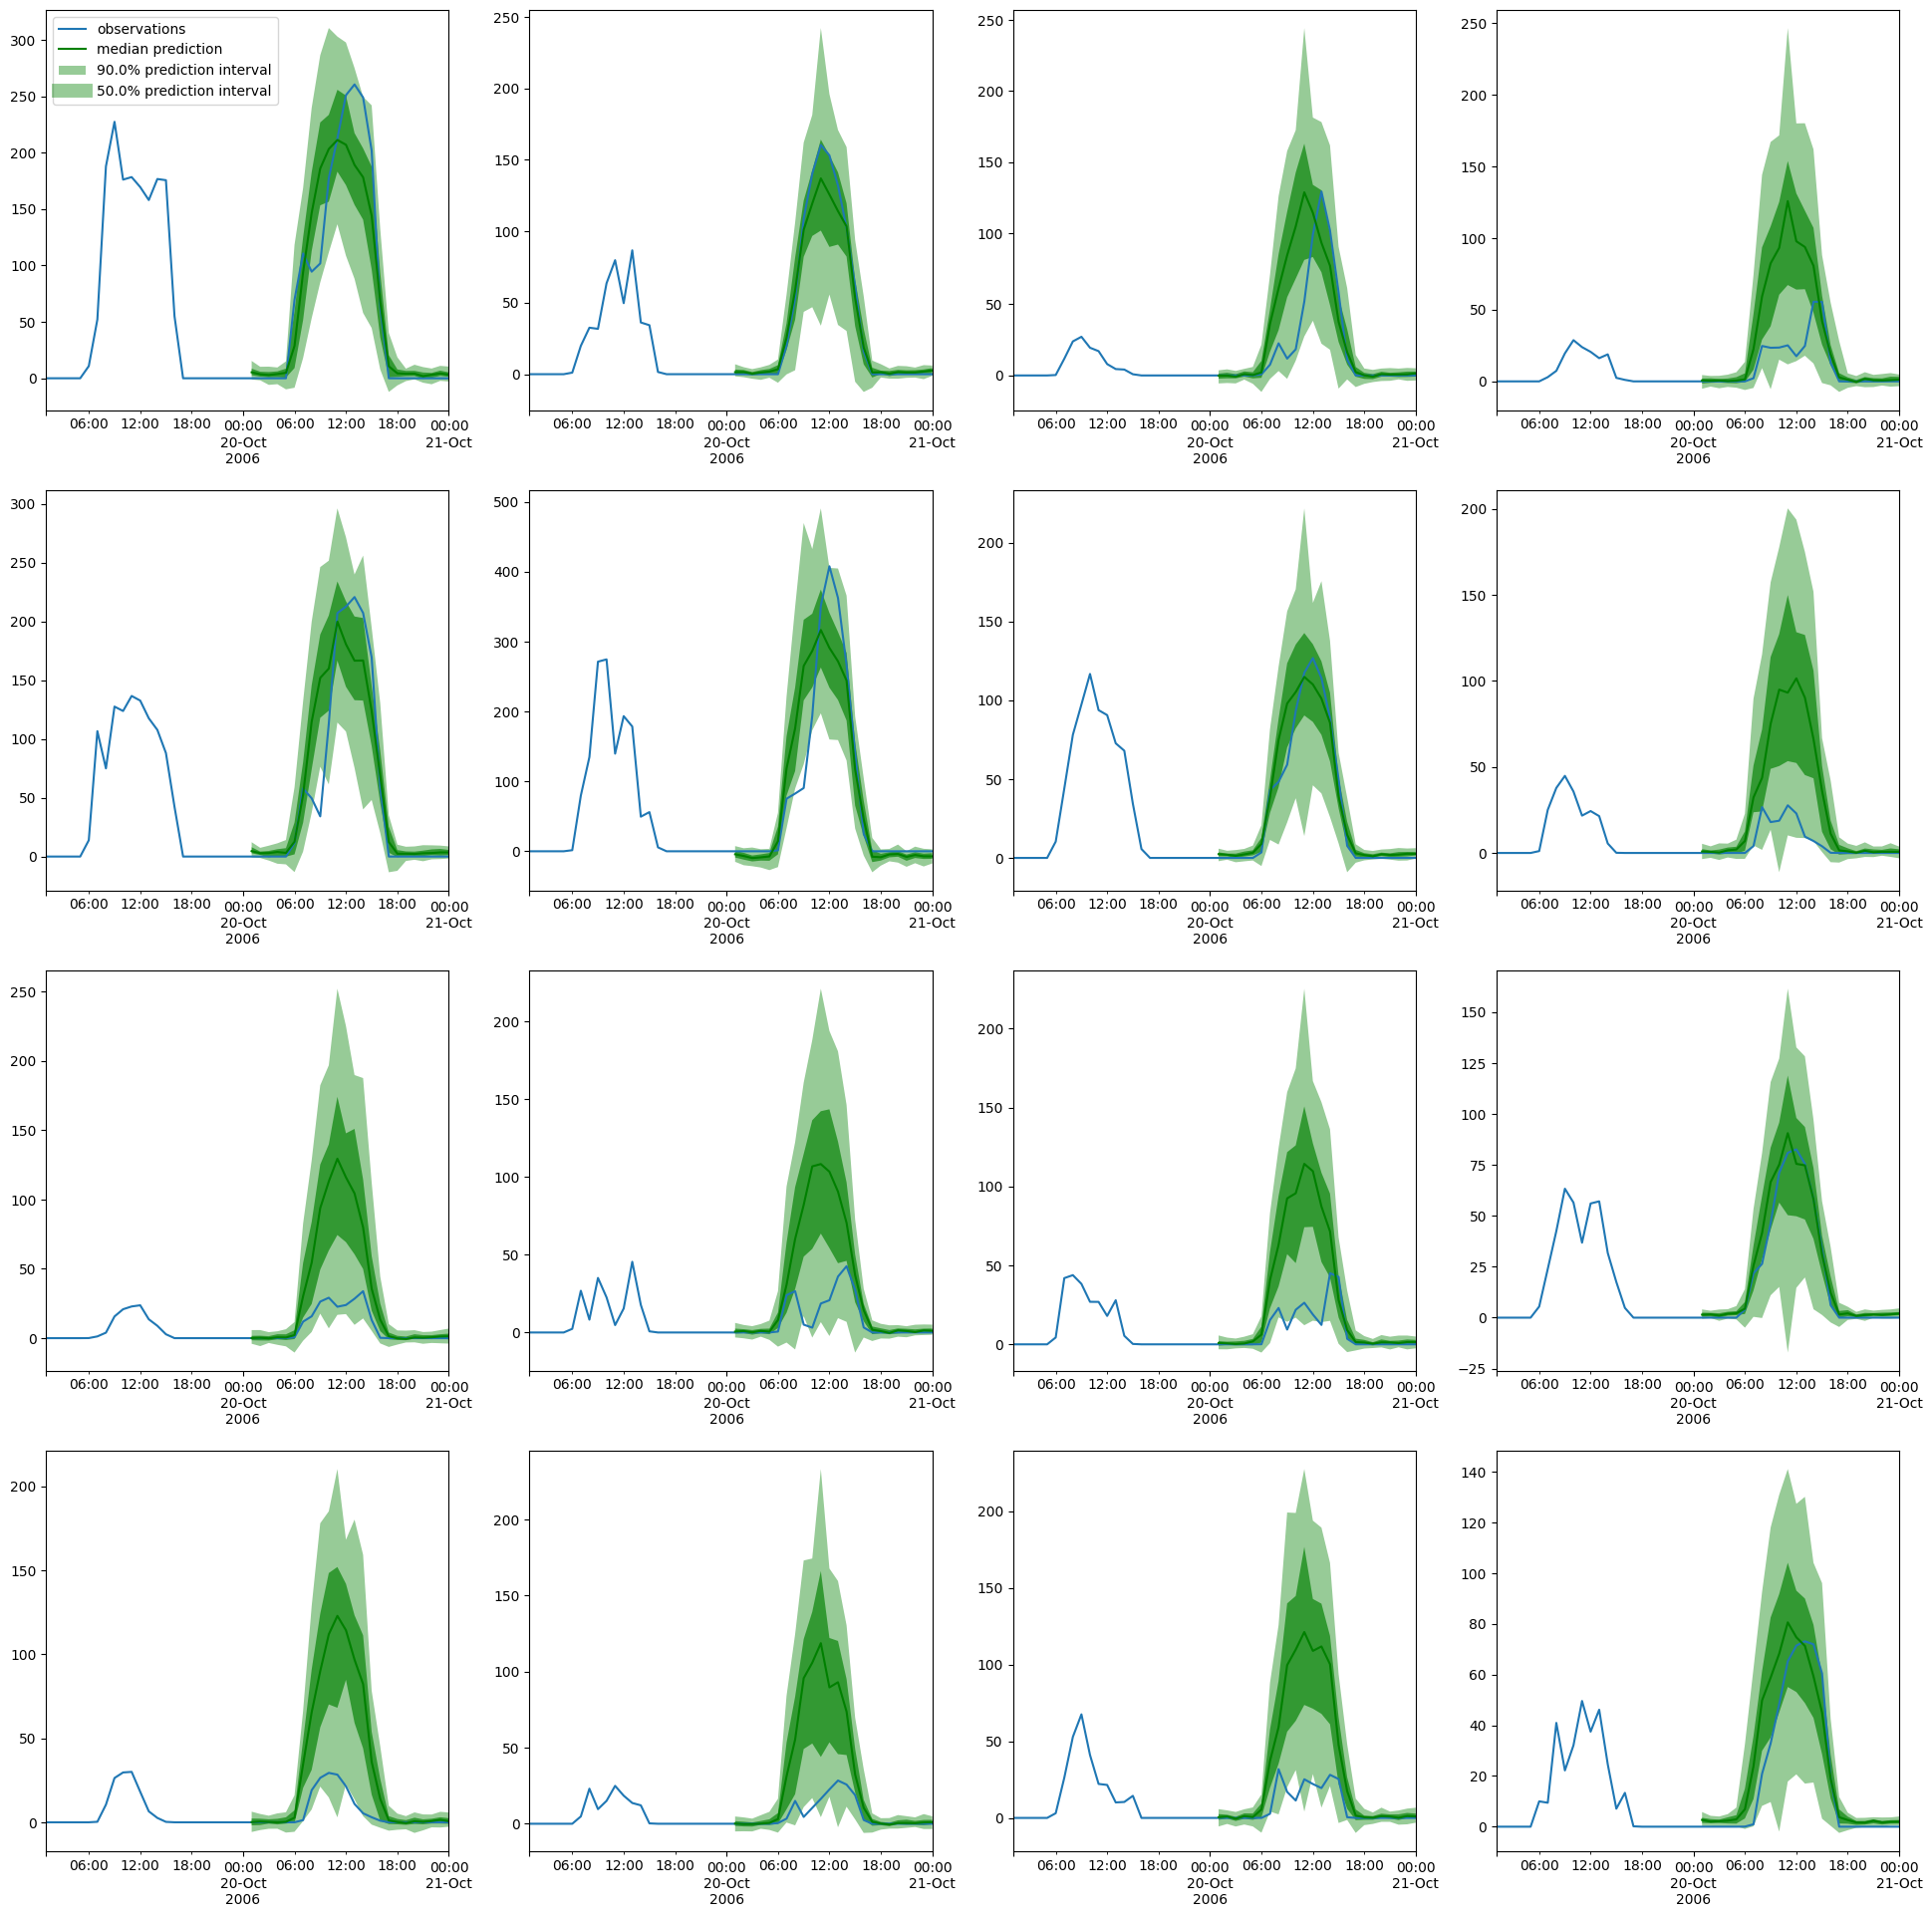

In [12]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()